In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

1. Get Data for a few stocks

In [2]:
stocks = ["AAPL","AMZN","GOOG","FB"]

stocks_data = {}
for fn in os.listdir('../dataset/price'):
    df = pd.read_csv('../dataset/price/'+fn)
    stocks_data[fn[:-4]] = df

2. Hyper parameters

In [3]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20
cur_LSTM_pars = {
                     'units': layer_units, 
                     'optimizer': optimizer, 
                     'batch_size': cur_batch_size, 
                     'epochs': cur_epochs
                }
scaler = StandardScaler()
    

3. Preprocessing

In [4]:
def preprocess_testdat(data, scaler, window_size, test):    
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test




  

4. Run LSTM

In [5]:
### Build a LSTM model and log model summary to Neptune ###    
def Run_LSTM(X_train, layer_units=50):     
    inp = tf.keras.Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = tf.keras.Model(inp, out)
    
    # Compile the LSTM neural net
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')    
    return model   


5. Errors and plot

In [6]:
rmse_data = []
mape_data = []
mae_data = []
mse_data = []

#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape


def calculate_error_and_plot(train,test):
    rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("RMSE = ", rmse_lstm)
    rmse_data.append(rmse_lstm)

    mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MAPE = ", mape_lstm)
    mape_data.append(mape_lstm)

    mae_val = mae(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MAE = ", mae_val)
    mae_data.append(mae_val)

    mse_val = mean_squared_error(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MSE = ", mse_val)
    mse_data.append(mse_val)
    
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")


6. Predict prices

2022-08-26 04:33:18.768993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-26 04:33:19.066900: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-26 04:33:19.066976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2022-08-26 04:33:19.067128: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-08-26 04:33:19.067194: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not

Epoch 1/15
32/32 [==============================] - 4s 112ms/step - loss: 0.3127 - val_loss: 0.1500
Epoch 2/15
32/32 [==============================] - 2s 76ms/step - loss: 0.1393 - val_loss: 0.0425
Epoch 3/15
32/32 [==============================] - 2s 70ms/step - loss: 0.0470 - val_loss: 0.0310
Epoch 4/15
32/32 [==============================] - 2s 72ms/step - loss: 0.0399 - val_loss: 0.0307
Epoch 5/15
32/32 [==============================] - 2s 69ms/step - loss: 0.0442 - val_loss: 0.0285
Epoch 6/15
32/32 [==============================] - 2s 66ms/step - loss: 0.0414 - val_loss: 0.0281
Epoch 7/15
32/32 [==============================] - 2s 65ms/step - loss: 0.0391 - val_loss: 0.0265
Epoch 8/15
32/32 [==============================] - 2s 76ms/step - loss: 0.0349 - val_loss: 0.0261
Epoch 9/15
32/32 [==============================] - 2s 67ms/step - loss: 0.0328 - val_loss: 0.0249
Epoch 10/15
32/32 [==============================] - 2s 64ms/step - loss: 0.0297 - val_loss: 0.0246
Epoch 11

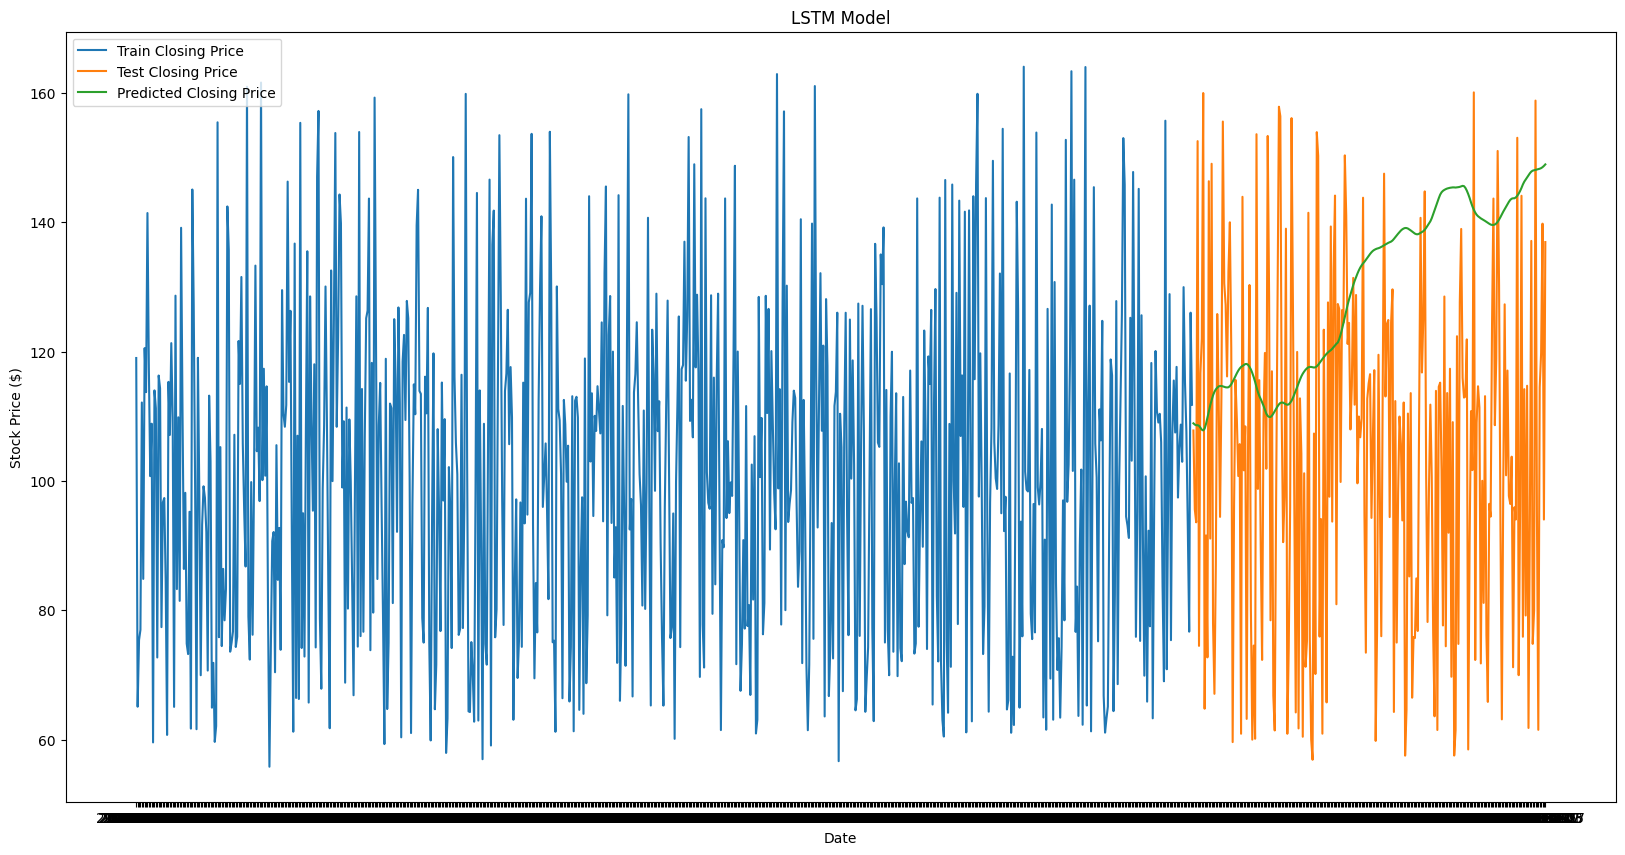

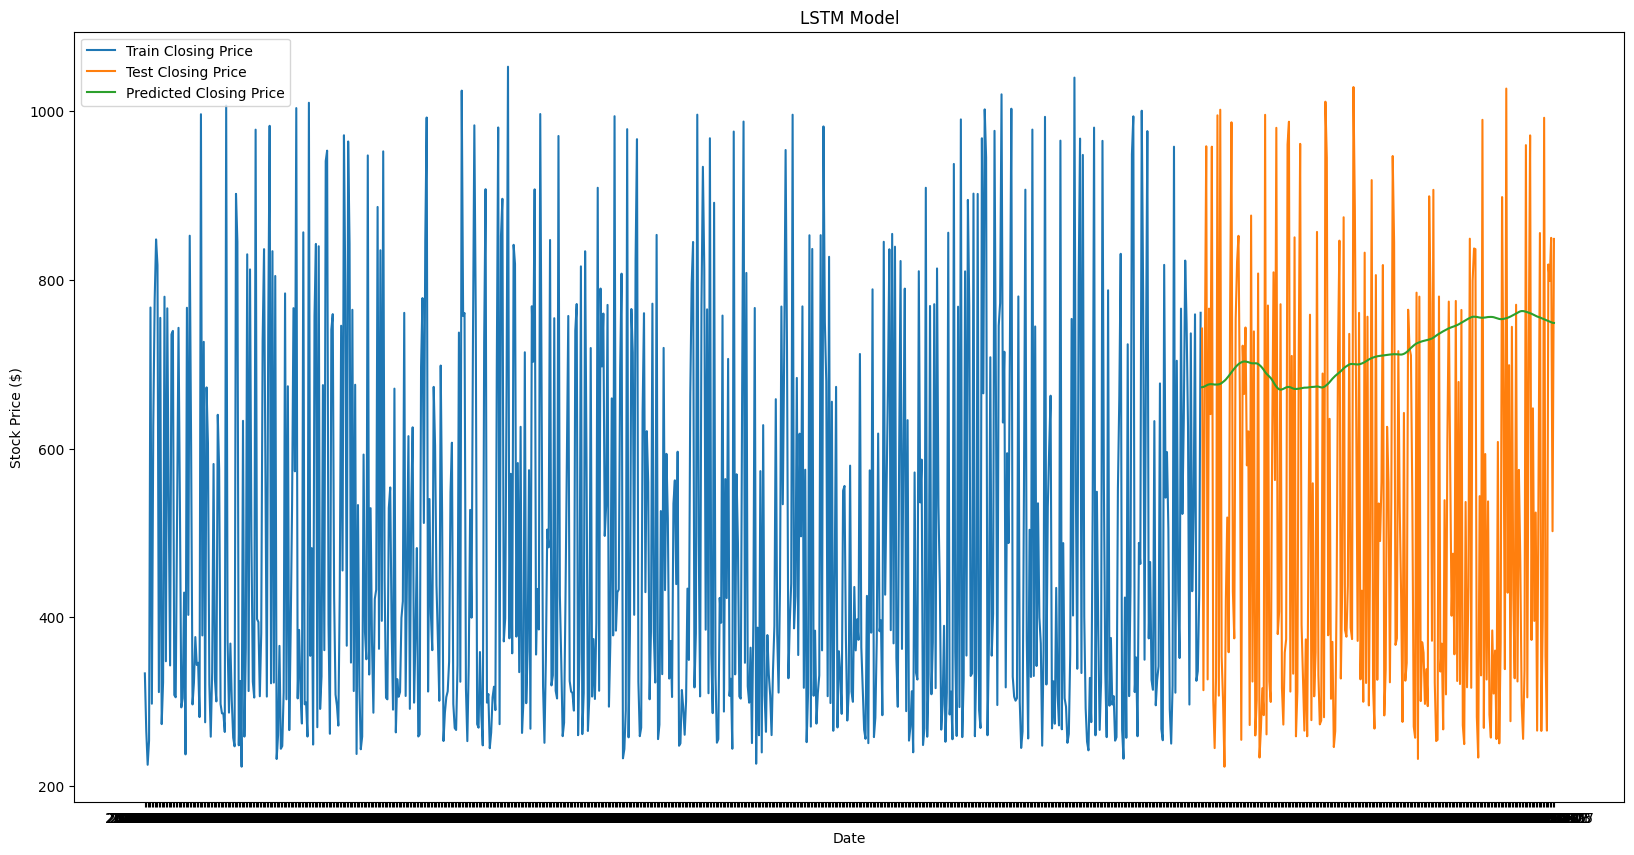

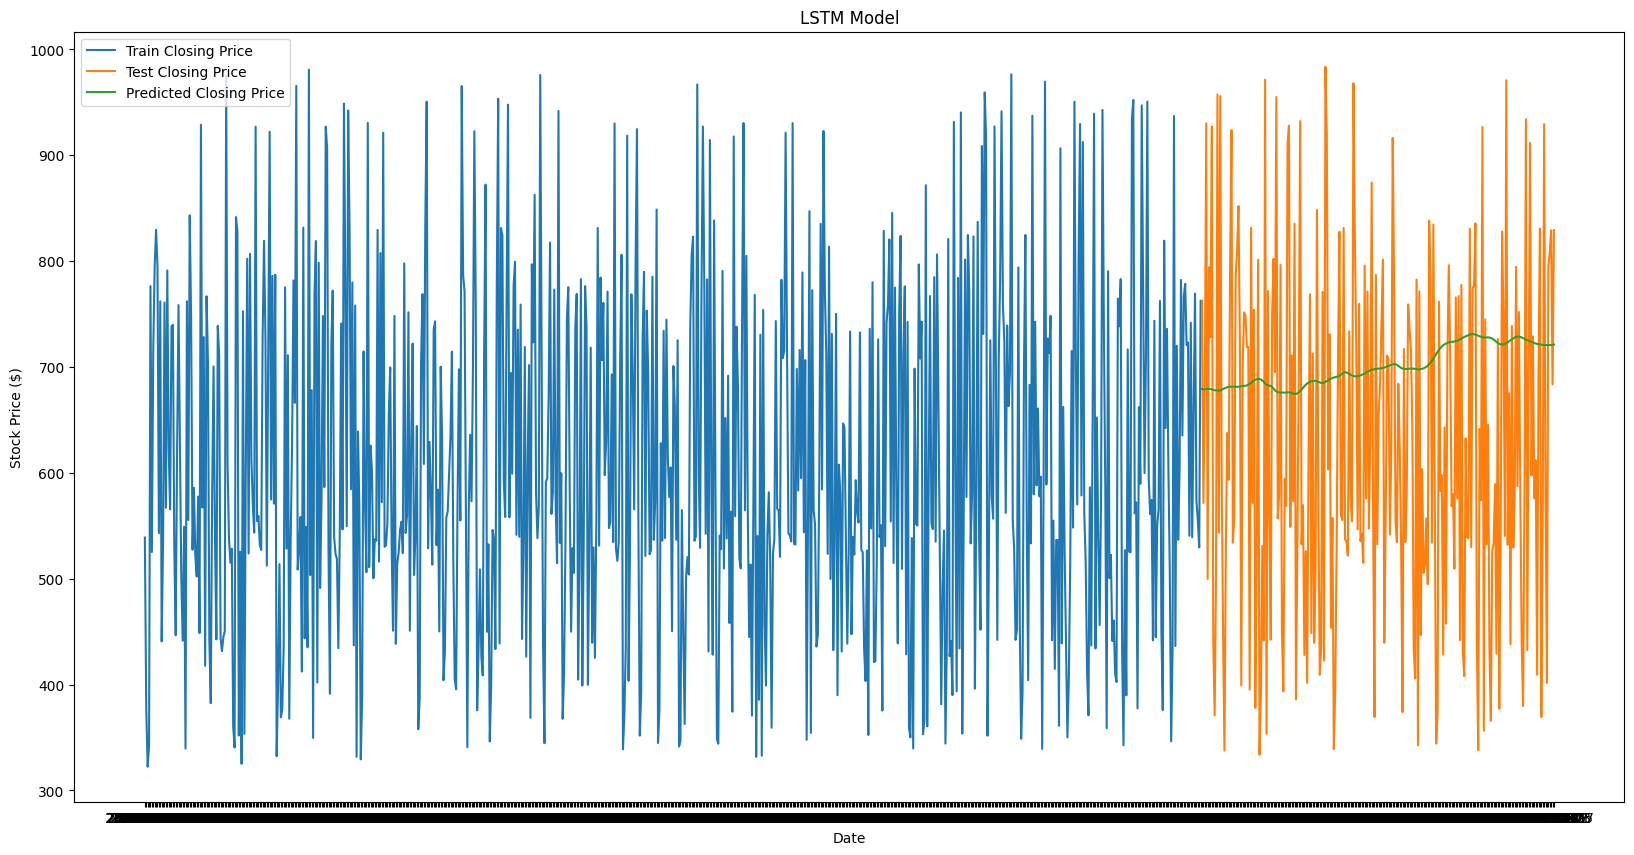

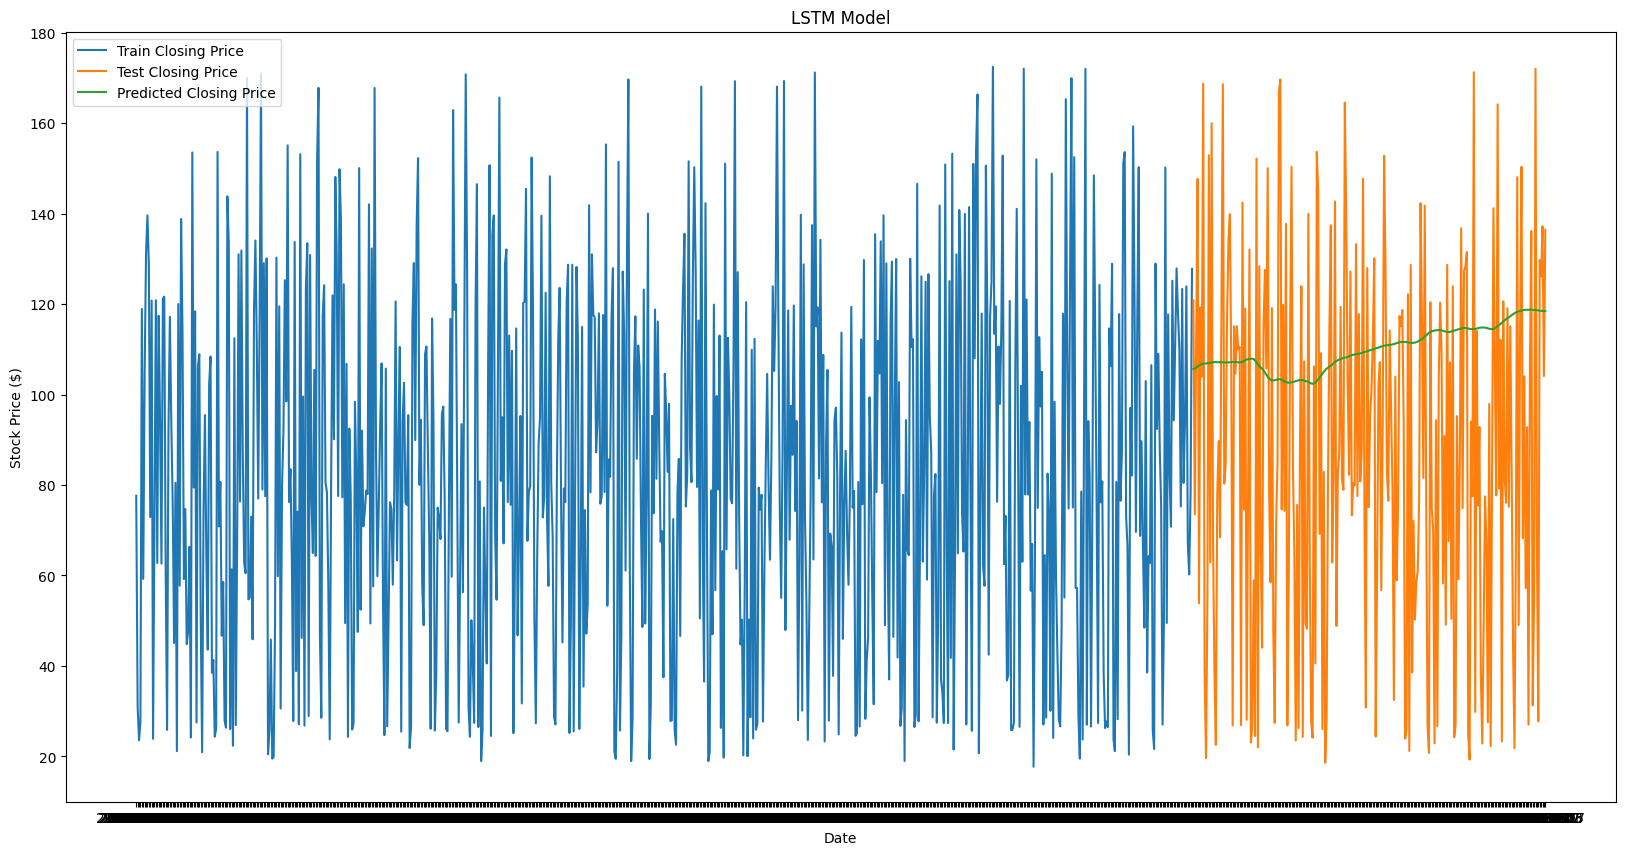

In [7]:
def dataset_split(df):
    train, validate, test = \
              np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
    return train, test

def scale(stock_data,train):
    def extract_seqX_outcomeY(data, N, offset):
        X, y = [], [] 
        for i in range(offset, len(data)):
            X.append(data[i-N:i])
            y.append(data[i])
        return np.array(X), np.array(y)
    scaled_data = scaler.fit_transform(stock_data[['Close']].values)
    scaled_data_train = scaled_data[:train.shape[0]]
    window_size = 50
    # We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
    X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)
    return X_train, y_train

def predict_stocks():
  for name in stocks:
    train,test = dataset_split(stocks_data[name])
    X_train, y_train = scale(stocks_data[name],train)
    
    ## training our model
    model = Run_LSTM(X_train, layer_units = layer_units)
    history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=False)
    
    print(name, " trained successfully")
    ## preprocess test data
    X_test = preprocess_testdat(stocks_data[name], scaler, 50, test)

    ##predict test data
    predicted_price_ = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price_)

    # Plot predicted price vs actual closing price 
    test['Predictions_lstm'] = predicted_price
    calculate_error_and_plot(train,test)
  

predict_stocks()



In [9]:
metrics = pd.DataFrame()
metrics['RMSE'] = rmse_data
metrics['MAE'] = mae_data
metrics['MAPE'] = mape_data
metrics['MSE'] = mse_data

metrics.rename(index = {0:"AAPL"}, inplace=True)
metrics.rename(index = {1:"AMZN"}, inplace=True)
metrics.rename(index = {2:"GOOG"}, inplace=True)
metrics.rename(index = {3:"FB"}, inplace=True)
metrics


,RMSE,MAE,MAPE,MSE
AAPL,39.825058,33.249987,39.394868,1586.035242
AMZN,309.537148,271.468161,76.401306,95813.246204
GOOG,183.379117,156.264359,30.115302,33627.900397
FB,47.337077,38.923464,90.096387,2240.798888


1. load the tweet data (only AAPL)

In [44]:
import re
import json
import pandas as pd
from dateutil.parser import parse
tweets_path = "../dataset/tweet"
dfx = pd.DataFrame

def load_tweets(path):
    df = []
    stocks_folders = ["AAPL"]
    for folder in stocks_folders:
        try:
            stocks_files = sorted(os.listdir(f'{path}/{folder}'))
            for stock_file in stocks_files:
                file_path = f'{path}/{folder}/{stock_file}'
                json_file = open(file_path, 'r')
                for line in json_file.readlines():
                    df_date = pd.json_normalize(json.loads(line))
                    df.append(df_date)                    
        except Exception as e:
            print(e)
    tweets_df = pd.concat(df,sort=False)    
    return tweets_df

tweets_df = load_tweets(tweets_path)
tweets_df = tweets_df.reset_index(drop=True)
tweets_df


,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,retweeted_status.quoted_status.filter_level,retweeted_status.quoted_status.lang,retweeted_status.quoted_status.entities.media,retweeted_status.quoted_status.extended_entities.media,is_quote_status,retweeted_status.is_quote_status,quoted_status.is_quote_status,retweeted_status.quoted_status.is_quote_status,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str
0,Wed Jan 01 03:59:03 +0000 2014,418229860210057216,418229860210057216,RT @philstockworld: Summary of Yesterday's Web...,web,False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Jan 01 03:29:29 +0000 2014,418222419485421568,418222419485421568,RT @philstockworld: Summary of Yesterday's Web...,web,False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Jan 01 18:08:47 +0000 2014,418443702579654656,418443702579654656,iTV Will Boost Apple http://t.co/8dup4cQc08 $A...,"<a href=""http://seekingalpha.com"" rel=""nofollo...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Jan 01 01:52:31 +0000 2014,418198017015959552,418198017015959552,#iPhone users are more intelligent than #Samsu...,web,False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Jan 01 01:18:36 +0000 2014,418189481607696384,418189481607696384,RT @philstockworld: Summary of Yesterday's Web...,web,False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,Thu Mar 31 12:33:09 +0000 2016,715517287491629058,715517287491629058,"AAPL Top news - Mar 31st, 2016 $AAPL https://t...","<a href=""http://www.sweetalpha.com"" rel=""nofol...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
20846,Thu Mar 31 12:34:45 +0000 2016,715517690123837441,715517690123837441,REVIEW: This is Apple's best iPad $AAPL https:...,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
20847,Thu Mar 31 19:26:38 +0000 2016,715621343958474753,715621343958474753,#Apple now collecting some ResearchKit data fr...,"<a href=""https://www.owler.com"" rel=""nofollow""...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
20848,Wed Mar 30 23:28:36 +0000 2016,715319849010929666,715319849010929666,Apple deal makes iPad Pro on-field device of c...,"<a href=""http://dlvr.it"" rel=""nofollow"">dlvr.i...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


2. Load Bert Model

In [36]:
import flair, torch
flair.device = torch.device('cpu') 
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-08-27 03:16:09,171 loading file /home/zgao/.flair/models/sentiment-en-mix-distillbert_4.pt


3. Preprocessing

In [45]:
def clean(tweet):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")

    # we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = user.sub('', tweet)
    return tweet
tweets = tweets_df[['created_at','id','text']]
for i in range(0,len(tweets['text'])):
    tweets['text'][i] = clean(tweets['text'][i])


/tmp/ipykernel_25077/4102998855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'][i] = clean(tweets['text'][i])


4. Predict

In [46]:
probs = []
sentiments = []

for tweet in tweets['text'].to_list():
    # make prediction
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# # add probability and sentiment predictions to tweets dataframe
tweets['probability'] = probs
tweets['sentiment'] = sentiments
tweets

/tmp/ipykernel_25077/1466277076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['probability'] = probs
/tmp/ipykernel_25077/1466277076.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment'] = sentiments


,created_at,id,text,probability,sentiment
0,Wed Jan 01 03:59:03 +0000 2014,418229860210057216,RT : Summary of Yesterday's Webcast Featuring ...,0.984792,NEGATIVE
1,Wed Jan 01 03:29:29 +0000 2014,418222419485421568,RT : Summary of Yesterday's Webcast Featuring ...,0.984792,NEGATIVE
2,Wed Jan 01 18:08:47 +0000 2014,418443702579654656,iTV Will Boost Apple http://t.co/8dup4cQc08 $A...,0.620186,NEGATIVE
3,Wed Jan 01 01:52:31 +0000 2014,418198017015959552,#iPhone users are more intelligent than #Samsu...,0.925398,NEGATIVE
4,Wed Jan 01 01:18:36 +0000 2014,418189481607696384,RT : Summary of Yesterday's Webcast Featuring ...,0.984792,NEGATIVE
...,...,...,...,...,...
20845,Thu Mar 31 12:33:09 +0000 2016,715517287491629058,"AAPL Top news - Mar 31st, 2016 $AAPL LTAUm5Hrkc",0.986407,POSITIVE
20846,Thu Mar 31 12:34:45 +0000 2016,715517690123837441,REVIEW: This is Apple's best iPad $AAPL LwLXsP...,0.994457,POSITIVE
20847,Thu Mar 31 19:26:38 +0000 2016,715621343958474753,#Apple now collecting some ResearchKit data fr...,0.742292,POSITIVE
20848,Wed Mar 30 23:28:36 +0000 2016,715319849010929666,Apple deal makes iPad Pro on-field device of c...,0.565382,POSITIVE


5. Change Date format

In [49]:
tweets['Date']=[pd.to_datetime(parse(x)).to_pydatetime().date() for x in tweets['created_at']]
tweets_data = tweets
tweets_data = tweets_data.groupby(['Date'])['sentiment'].apply(pd.Series.mode).reset_index()
tweets_data.drop(['level_1'], axis=1)
#tweets_data

/tmp/ipykernel_25077/49500860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Date']=[pd.to_datetime(parse(x)).to_pydatetime().date() for x in tweets['created_at']]


,Date,sentiment
0,2013-12-31,NEGATIVE
1,2014-01-01,NEGATIVE
2,2014-01-02,NEGATIVE
3,2014-01-03,NEGATIVE
4,2014-01-04,NEGATIVE
...,...,...
796,2016-03-27,NEGATIVE
797,2016-03-28,NEGATIVE
798,2016-03-29,NEGATIVE
799,2016-03-30,NEGATIVE


6. Get relavant stock data from yfinance

In [51]:
import yfinance as yf
start_date = tweets_data['Date'][0].strftime('%Y-%m-%d')
end_date = tweets_data['Date'][len(tweets_data)-1].strftime('%Y-%m-%d')
aapl = yf.Ticker("AAPL")
aapl_stock = aapl.history(
    start=start_date,
    end=end_date,
).reset_index()
aapl_stock["change"] = aapl_stock['Close'].pct_change().dropna()
aapl_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,change
0,2013-12-30,17.580984,17.663927,17.418879,17.488262,253629600,0.0,0.0,NaN
1,2013-12-31,17.477218,17.701450,17.471856,17.693251,223084400,0.0,0.0,0.011721
2,2014-01-02,17.524849,17.567425,17.409421,17.444427,234684800,0.0,0.0,-0.014063
3,2014-01-03,17.435907,17.462397,17.043893,17.061239,392467600,0.0,0.0,-0.021966
4,2014-01-06,16.949912,17.244788,16.828492,17.154276,412610800,0.0,0.0,0.005453
...,...,...,...,...,...,...,...,...,...
561,2016-03-23,24.543000,24.678991,24.409313,24.462326,102814000,0.0,0.0,-0.005529
562,2016-03-24,24.310206,24.489991,24.176519,24.356304,104532000,0.0,0.0,-0.004334
563,2016-03-28,24.432372,24.476166,24.215707,24.245672,77645600,0.0,0.0,-0.004542
564,2016-03-29,24.176517,24.844950,24.174211,24.819595,124760400,0.0,0.0,0.023671


7. make original data (positive or negative)

In [52]:
tweets_data['Original']=""
tweets_data['Price']=""
indx=0
for i in range (0,len(tweets_data)):
    for j in range (0,len(msft_stock)):
        get_tweet_date=tweets_data['Date'][i]
        get_stock_date=msft_stock['Date'][j]
        if(get_stock_date==get_tweet_date):
            tweets_data['Price'][i]=msft_stock['Close'][j]
            #print(get_stock_date," ",get_tweet_date)
            if msft_stock['change'][j]<0:
                tweets_data['Original'][i]="NEGATIVE"
            else:
                tweets_data['Original'][i]="POSITIVE"
            break

tweets_data

/tmp/ipykernel_25077/1025883930.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if(get_stock_date==get_tweet_date):
/tmp/ipykernel_25077/1025883930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Price'][i]=msft_stock['Close'][j]
/tmp/ipykernel_25077/1025883930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Original'][i]="POSITIVE"
/tmp/ipykernel_25077/1025883930.py:12: SettingWithC

,Date,level_1,sentiment,Original,Price
0,2013-12-31,0,NEGATIVE,POSITIVE,31.87022
1,2014-01-01,0,NEGATIVE,,
2,2014-01-02,0,NEGATIVE,NEGATIVE,31.657234
3,2014-01-03,0,NEGATIVE,NEGATIVE,31.444258
4,2014-01-04,0,NEGATIVE,,
...,...,...,...,...,...
796,2016-03-27,0,NEGATIVE,,
797,2016-03-28,0,NEGATIVE,NEGATIVE,48.481926
798,2016-03-29,0,NEGATIVE,POSITIVE,49.541405
799,2016-03-30,0,NEGATIVE,POSITIVE,49.849277


8. Remove weekends

In [53]:
tweets_data['sentiment'].replace('', np.nan, inplace=True)
tweets_data['Original'].replace('', np.nan, inplace=True)
tweets_data.dropna(subset=['sentiment'], inplace=True)
tweets_data.dropna(subset=['Original'], inplace=True)
tweets_data.dropna(subset=['Price'], inplace=True)

9. Accuracy, recall and precision

In [54]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
confusion_matr = confusion_matrix(tweets_data['Original'],tweets_data['sentiment'])
tweets_data['sentiment'] = tweets_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0}).astype(int)
tweets_data['Original'] = tweets_data['Original'].map({'POSITIVE': 1, 'NEGATIVE': 0}).astype(int)
precision = precision_score( tweets_data['Original'],tweets_data['sentiment'])
recall = recall_score( tweets_data['Original'],tweets_data['sentiment'])
accuracy = accuracy_score( tweets_data['Original'],tweets_data['sentiment'])
print(confusion_matr,precision,recall,accuracy)

[[251  13]
 [271  11]] 0.4583333333333333 0.03900709219858156 0.47985347985347987


In [57]:
train,test = dataset_split(stocks_data['AAPL'])
X_train,y_train = scale(stocks_data['AAPL'],train)

   
## training our model
model = Run_LSTM(X_train,layer_units = layer_units)
history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True) 

NameError: name 'scale' is not defined

In [83]:

X_test, Y_test = extract_seqX_outcomeY(tweets_data['Price'], 50, 50)
# X_test = np.array(X_test)    
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_price_ = model.predict(X_test)
# predicted_price = scaler.inverse_transform(predicted_price_)



In [77]:
X_test

array([[31.657245635986328, 31.44424819946289, 30.779760360717773, ...,
        32.63277053833008, 32.52119064331055, 32.35810470581055],
       [31.44424819946289, 30.779760360717773, 31.018310546875, ...,
        32.52119064331055, 32.35810470581055, 32.65851593017578],
       [30.779760360717773, 31.018310546875, 30.464555740356445, ...,
        32.35810470581055, 32.65851593017578, 33.94597244262695],
       ...,
       [46.05047607421875, 46.05047607421875, 46.80569839477539, ...,
        48.96185302734375, 48.87131118774414, 49.0886344909668],
       [46.05047607421875, 46.80569839477539, 49.52988052368164, ...,
        48.87131118774414, 49.0886344909668, 48.48194122314453],
       [46.80569839477539, 49.52988052368164, 49.52988052368164, ...,
        49.0886344909668, 48.48194122314453, 49.54140090942383]],
      dtype=object)

In [69]:
tweets_data=tweets_data.reset_index()

In [68]:
tweets_data

,Date,level_1,sentiment,Original,Price
1,2014-01-02,0,0,1,31.657246
2,2014-01-03,0,0,0,31.444248
5,2014-01-06,0,0,0,30.77976
6,2014-01-07,0,0,1,31.018311
7,2014-01-08,0,0,0,30.464556
...,...,...,...,...,...
795,2016-03-23,0,0,0,48.871311
796,2016-03-24,0,0,1,49.088634
800,2016-03-28,0,0,0,48.481941
801,2016-03-29,0,0,1,49.541401
